# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# MNIST

In [2]:
# sklearn can fetch this data set
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [19]:
# lets look at its structure
print(mnist['DESCR'])
X, y = mnist['data'], mnist['target']
print(X.shape)    # (70000, 784) bc it has 70K images, each 28x28
print(y.shape)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

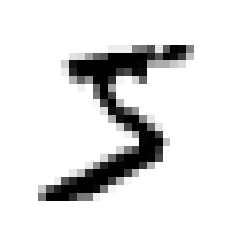

'5'

In [20]:
# lets look at one digit
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

# to confirm
y[0]    

In [21]:
# notice y[0] is a string --> cast to int
y = y.astype(np.uint8)
y[0]    

5

## Splitting Train / Test

In [22]:
# MNIST comes already split, and training set shuffled for good CV
#.   first 60k = train, last 10k = test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training Binary Classifier

In [23]:
# lets simplify example to just finding whether or not a digit is a 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [24]:
# train a Stochastic Gradient Decent Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [26]:
# try it out real quick
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

In [27]:
# many ways to measure performance of a Classifier

## Measuring Accuracy using Cross-Validation

In [30]:
# could implement our own stratified cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# creates folds using stratified sampling
skfolds = StratifiedKFold(n_splits=3)

# iterates through each n_splits folds and creates its own model
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [31]:
# but lets use cross_val_score() anayway
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [32]:
# these accuracies seem super high!
# but lets check the score of a dumb classifier that always classifies as not-5
from sklearn.base import BaseEstimator

# define dumb classifier
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
# test its accuracy
cross_val_score(Never5Classifier(), X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [33]:
# Still a high accuracy! This is because only ~10% of data is 5's --> skewed dataset
# this is why accuracy usually isn't the best performance measure for classification

## Confusion Matrix

In [36]:
from sklearn.model_selection import cross_val_predict

# similar to cross_val_score but returns predictions of each fold based on training from all other folds
#.  this is considered 'clean' bc predicts on items that were never used for training
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)   # shape = (60000,)

In [42]:
from sklearn.metrics import confusion_matrix

# make confusion matrix from correct values and CV predictions
confusion_matrix(y_train_5, y_train_pred)

# Output:
# row = actual class, col = predicted class
# [[non-5's predicted non-5,    non-5's predicted 5],
#  [5's predicted non-5,        5's predicted 5]]

array([[53892,   687],
       [ 1891,  3530]])

In [43]:
# perfect model would have a diagonal matrix
y_train_perfect_pred = y_train_5
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]])